# Gradient Computation Method with PEtab in Julia

In several modeling tasks like model fitting to data, sensitivity analysis, identifiability analysis, and Bayesian inference, having access to model derivatives with respect to model parameter is often helpful, for example, it typically speeds up parameter estimation. When importing a PEtab problem, PEtab.jl automatically generates functions for computing the likelihood (measures the deviation between model predictions and experimental observations) and its derivatives (Hessian and gradient).

Regarding gradients, PEtab.jl supports several methods. The three most performant are:

- **Forward-mode Automatic Differentiation (AD)** via [ForwardDiff.jl](https://github.com/JuliaDiff/ForwardDiff.jl), suitable for smaller models.
- **Forward-sensitivity Analysis**, here the model sensitives are computed along with the ODE solution. The sensitivities are then used to compute the gradient. Suitable for smaller models.
- **Adjoint Sensitivity Analysis**, here an adjoint ODE-system is solved backward with time. The adjoint solution is then used to compute the gradient. Suitable for larger models.

This notebook covers how to select the best gradient method for a PEtab problem, and how to benchmark different methods. While PEtab is designed for parameter estimation, and Bayesian inference, the key problem task in this notebook is to differentiate ODE models. Therefore, lessons from here also applies to cases like scientific machine learning.

## Setup

The packages needed are:

- **PEtab.jl**: For importing PEtab problems.
- **OrdinaryDiffEq.jl** and **Sundials.jl**: For simulating ODE models.
- **Zygote.jl** and **SciMLSensitivity.jl**: For computing gradients with adjoint sensitivity analysis.
- **Plots.jl** and **StatsPlots.jl**: For visualizing simulation results.

In [1]:
using OrdinaryDiffEq, Sundials, PEtab, Plots, StatsPlots, SciMLSensitivity, Zygote

## Computing gradients with different methods

Here we demonstrate three ways of computing the gradient for a small Jak-Stat signaling model, with is PEtab problem files located at *Assets/Boehm_JProteomeRes2014/*. To begin, we import the PEtab problem into Julia, detailed instructions on model import and be found in this [notebook](https://github.com/sebapersson/SysBioNotebooks/blob/main/Simulate_model/PEtab_ODE.ipynb).

In [2]:
path_petab_problem = joinpath(@__DIR__, "Assets", "Boehm_JProteomeRes2014", "Boehm_JProteomeRes2014.yaml")
petab_model = PEtabModel(path_petab_problem; verbose=false)

PEtabModel for model Boehm_JProteomeRes2014. ODE-system has 8 states and 10 parameters.
Generated Julia files are at /home/sebpe/Dropbox/PhD/Projects/SysBioNotebooks/PEtab/Assets/Boehm_JProteomeRes2014/Julia_model_files

When constructing a `PEtabODEProblem`, the method for gradient computation can be specified with the `gradient_method` argument. A list of available methods can be found [here](https://sebapersson.github.io/PEtab.jl/stable/Gradient_hessian_support/). Typically, the most performant options are `:ForwardDiff` (forward-mode AD), `:ForwardEquations` (forward-sensitivity analysis), and `:Adjoint` (adjoint sensitivity analysis):

In [3]:
prob1 = PEtabODEProblem(petab_model, gradient_method=:ForwardDiff, verbose=false)
prob2 = PEtabODEProblem(petab_model, gradient_method=:ForwardEquations, verbose=false)
prob3 = PEtabODEProblem(petab_model, gradient_method=:Adjoint, verbose=false)
nothing

Gradient computations for a parameter vector (below `xpetab`) is performed in-place, therefore we must provide the gradient vector to the gradient function.

In [4]:
xpetab = prob1.θ_nominalT
# similar - create the type of vector that xpetab is
g1, g2, g3 = similar(xpetab), similar(xpetab), similar(xpetab)
prob1.compute_gradient!(g1, xpetab)
prob2.compute_gradient!(g2, xpetab)
prob3.compute_gradient!(g3, xpetab)
println("g3 = ", g3')

g3 = 

[0.022034543624598054

 0.055322755666278145 0.005787962822221311 0.005404165532490141 -4.515958143579751e-5 0.007914513131483775 0.01078122126000923 0.02403689747233729 0.0191914295616005]


To compare/benchmark gradient computation methods we should consider both runtime and accuracy. Starting with accuracy, we can create a high accuracy reference gradient by using a higher-order finite-difference approach combined with the `Rodas4` ODE solver set to low tolerances (highly accurate ODE-solution):

In [5]:
using FiniteDifferences
prob_highacc = PEtabODEProblem(petab_model, ode_solver=ODESolver(Rodas4(), abstol=1e-12, reltol=1e-12), verbose=false)
grad_highacc = FiniteDifferences.grad(central_fdm(5, 1), prob_highacc.compute_cost, xpetab)[1]

9-element Vector{Float64}:
  0.02203470205830794
  0.05532275572572083
  0.005788000138131559
  0.005404405380175574
 -4.516042899712248e-5
  0.007914100091919986
  0.010781237206148066
  0.024036842929870465
  0.01919140432499235

Where `prob_highacc.compute_cost` is the function computing the likelihood. Now we can compare both runtime and accuracy:

In [6]:
using Printf # For nice printing
runtime_prob1, runtime_prob2, runtime_prob3 = 0.0, 0.0, 0.0
g1, g2, g3 = similar(xpetab), similar(xpetab), similar(xpetab)

# Compute 10 times and take mean
for i in 1:10
    runtime_prob1 += @elapsed prob1.compute_gradient!(g1, xpetab)
    runtime_prob2 += @elapsed prob2.compute_gradient!(g2, xpetab)
    runtime_prob3 += @elapsed prob3.compute_gradient!(g3, xpetab)
end
# ℓ₂-norm
acc_prob1 = sqrt(sum((g1 - grad_highacc).^2))
acc_prob2 = sqrt(sum((g2 - grad_highacc).^2))
acc_prob3 = sqrt(sum((g3 - grad_highacc).^2))

@printf("ForwardDiff      : Runtime = %.2e seconds. Acc = %.2e\n", runtime_prob1/10, acc_prob1)
@printf("ForwardEquations : Runtime = %.2e seconds. Acc = %.2e\n", runtime_prob2/10, acc_prob2)
@printf("Adjoint          : Runtime = %.2e seconds. Acc = %.2e\n", runtime_prob3/10, acc_prob3)

ForwardDiff      : Runtime = 4.65e-03 seconds. Acc = 1.48e-06
ForwardEquations : Runtime = 4.59e-03 seconds. Acc = 1.08e-06
Adjoint          : Runtime = 6.23e-01 seconds. Acc = 5.08e-07


All methods compute accurate gradients as seen by the $\ell_2$-norm. Notably though, the adjoint method is slower, which is because this model is small (only 8 species). Adjoint sensitivity analysis is suitable for larger models (see below).

To better compare the `ForwardDiff` and `ForwardEquations` methods we should consider more than one parameter vector (`xpetab` above). Because in practical modeling scenarios the model is not always simulated close to the parameter values specified in `xpetab` (often the reported values). For instance, during parameter estimation or while exploring the parameter space, the model is simulated for random parameter combinations. To assess we can generate a set of random parameter vectors within the constraints defined by the PEtab problem. For example, we could generate 200 random parameter combinations:

In [7]:
xrandom = generate_startguesses(prob1, 200)

9×200 Matrix{Float64}:
  0.375   1.875  -2.125  -1.475  -0.125  …   2.775  -3.125   4.175  -4.275
  1.675  -3.325  -4.225   3.875  -2.775     -1.525  -1.075   3.775   1.775
 -0.225   1.875   2.575  -1.275  -3.975     -0.475   2.425  -0.575  -0.825
 -0.025   2.875  -3.425   2.425  -4.075     -3.175   1.925  -1.875   4.875
 -4.725   4.225   4.075  -2.725   0.425      2.625   0.925   4.125  -1.725
 -4.275   0.725  -4.575   4.425   2.175  …  -4.875  -3.725  -3.775   1.875
  4.675   1.525  -4.075  -3.725   2.875     -3.375   2.575   4.925   1.675
  2.975   3.225  -3.175  -2.975   3.825     -0.575  -1.225  -1.275   0.525
 -3.875  -4.375   1.275   2.825   2.225     -1.075   4.475  -3.625   3.925

Each column of `xrandom` represents a distinct parameter vector. With these random parameter combinations, we can do a more realistic comparison (note we can also check accuracy - however runtime for that is substantial and thus skipped here :)

In [8]:
runtime_prob1, runtime_prob2 = zeros(200), zeros(200)
g1, g2 = similar(xpetab), similar(xpetab)
for i in 1:200
    # Take mean of three runs
    x = xrandom[:, i]
    for j in 1:3
        runtime_prob1[i] += @elapsed prob1.compute_gradient!(g1, x)
        runtime_prob2[i] += @elapsed prob2.compute_gradient!(g2, x)
    end
    runtime_prob1[i] /= 3
    runtime_prob2[i] /= 3
end

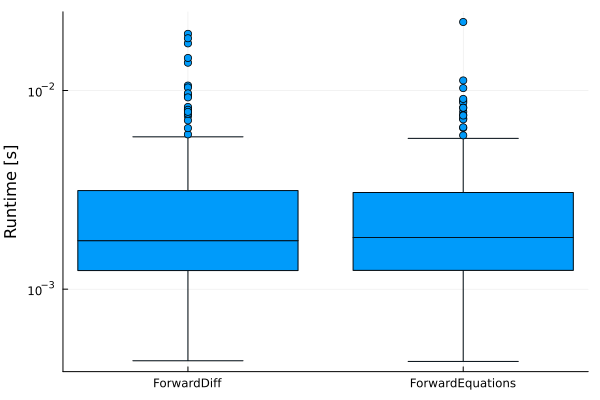

In [9]:
xaxis = repeat(["ForwardDiff", "ForwardEquations"], outer=100)
boxplot(xaxis, vcat(runtime_prob1, runtime_prob2), ylabel="Runtime [s]", label=false, yaxis=:log10)

Overall we see that `:ForwardDiff` (default in PEtab) is slightly faster.

### Tuning ForwardDiff

When using `:ForwardDiff` to compute model derivatives there is one tuning parameter; `chunksize`. In a naive implementation of forward-mode AD, one component of the gradient is computed per forward pass, thus as many forward passes as parameters are required to compute the gradient. However, in [ForwardDiff.jl](https://github.com/JuliaDiff/ForwardDiff.jl) `chunksize` number of gradient components can be computed per forward pass. A balance must be struck in choosing the `chunksize`: too small and there are too many forward simulation; too large, and too much memory is allocated. While the default `chunksize` is often effective, fine-tuning it can decrease runtime.

The maximum `chunksize` is the number of parameters to estimate that are a part of the ODE-model (internally PEtab distinguishes between parameters that are a part of the ODE-system or not). This can can be accessed via:

In [10]:
node_param = length(prob1.θ_indices.θ_dynamic_names)

6

We can now compare different chunk-sizes for 200 random parameter vectors

In [11]:
# Create PEtabODEProblem with different chunksize
probs = Vector{PEtabODEProblem}(undef, 6)
for i in 1:6
    probs[i] = PEtabODEProblem(petab_model, chunksize=i, gradient_method=:ForwardDiff; verbose=false)
    # Pre-compile gradient for fair benchmark
    probs[i].compute_gradient!(g1, xpetab)
end

runtime = [zeros(200) for i in 1:6]
for i in 1:200
    x = xrandom[:, i]
    for j in 1:6
        runtime[j][i] += @elapsed probs[j].compute_gradient!(g1, x)
    end
end

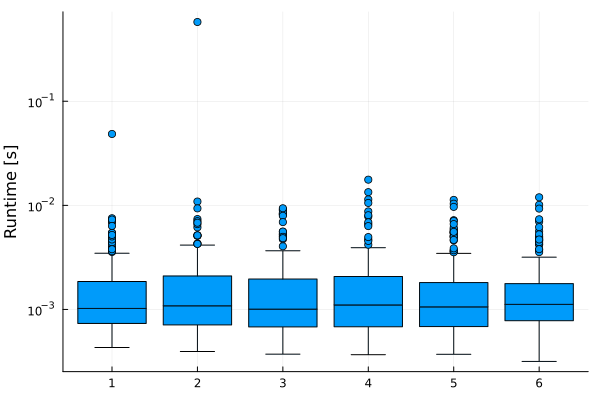

In [12]:
xaxis = repeat(["1", "2", "3", "4", "5", "6"], outer=100)
boxplot(xaxis, reduce(vcat, runtime), ylabel="Runtime [s]", label=false, yaxis=:log10)

The impact of `chunksize` on performance is small. Nevertheless, for more complex models with more than 20 ODEs, adjusting the `chunksize` can lead to notable reductions in runtime. However, the process of tuning `chunksize` itself consumes time. This highlights the need for novel automatic algorithms for tuning `chunksize`.

## Adjoint sensitivity analysis (larger models)

For smaller models with up to 75 parameters, forward gradient computation methods like forward-mode AD and forward sensitivity equations are typically most efficient. However, for larger models, adjoint sensitivity is more efficient.

As an example, we can examine a more complex signaling model of Smad-complex formation. The PEtab problem files for this model are available at *Assets/Lucarelli_CellSystems2018/*.

In [13]:
path_petab_problem = joinpath(@__DIR__, "Assets", "Lucarelli_CellSystems2018", "Lucarelli_CellSystems2018.yaml")
petab_model = PEtabModel(path_petab_problem; verbose=false)

PEtabModel for model Lucarelli_CellSystems2018. ODE-system has 33 states and 107 parameters.
Generated Julia files are at /home/sebpe/Dropbox/PhD/Projects/SysBioNotebooks/PEtab/Assets/Lucarelli_CellSystems2018/Julia_model_files

First, we can compare runtime for adjoint sensitivity analysis against forward-mode AD:

In [14]:
prob1 = PEtabODEProblem(petab_model, gradient_method=:ForwardDiff, 
                        ode_solver=ODESolver(QNDF()),
                        ode_solver_gradient=ODESolver(QNDF()), verbose=false, 
                        sparse_jacobian=false)
prob2 = PEtabODEProblem(petab_model, gradient_method=:ForwardDiff, 
                        ode_solver=ODESolver(QNDF()),
                        ode_solver_gradient=ODESolver(CVODE_BDF(), 
                                                      abstol_adj=1e-3, reltol_adj=1e-8), 
                        verbose=false, 
                        sparse_jacobian=false)
# Reported parameter values 
xpetab = prob1.θ_nominalT
nothing

In [15]:
prob2 = PEtabODEProblem(petab_model, gradient_method=:Adjoint, 
                        ode_solver=ODESolver(QNDF()),
                        ode_solver_gradient=ODESolver(CVODE_BDF()),
                        sparse_jacobian=false, 
                        verbose=false)         
nothing

We set a lot of options were set for the adjoint sensitivity analysis above. We will delve into the details later, first let us compare runtime.

In [16]:
g1, g2 = similar(xpetab), similar(xpetab)
# For precompiling
prob1.compute_gradient!(g1, xpetab)
prob2.compute_gradient!(g2, xpetab)
time1 = @elapsed prob1.compute_gradient!(g1, xpetab)
time2 = @elapsed prob2.compute_gradient!(g2, xpetab)
@printf("Runtime forward = %.2e seconds\n", time1)
@printf("Runtime adjoint = %.2e seconds\n", time2)

Runtime forward = 2.33e+00 seconds
Runtime adjoint = 1.30e+01 seconds


Internal error: stack overflow in type inference of solve_ode_no_pre_equlibrium(SciMLBase.ODEProblem{Array{Float64, 1}, Tuple{Float64, Float64}, true, Array{Float64, 1}, SciMLBase.ODEFunction{true, SciMLBase.FullSpecialize, ModelingToolkit.var"#k#503"{RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋arg1, :ˍ₋arg2, :t), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xfbc88608, 0x646b0cbd, 0x7a6b0a38, 0x68da4e3b, 0xcbf3fdc2), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :ˍ₋arg1, :ˍ₋arg2, :t), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xffe74239, 0x32b162a7, 0x393b6b95, 0xa52dd6a6, 0x49109f3d), Nothing}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, ModelingToolkit.var"#___jac#509"{RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋arg1, :ˍ₋arg2, :t), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x75a12626, 0xd772421c, 0x80eb7670, 0xc050d79b, 0x96d74b25), Nothing}, R

As we see the adjoint approach is faster.

To get the best performance of adjoint sensitivity analysis several factors must be considered. Details of the math behind it can be found [here](https://docs.sciml.ai/SciMLSensitivity/stable/sensitivity_math/), but briefly for adjoint sensitivity analysis an adjoint ODE must be solved backward in time, and a quadrature (integral) must be computed. Three key factors affecting performance are choice of adjoint algorithm, the method for computing the Vector-Jacobian Product (VJP), and ODE solver. 

1. **Adjoint Algorithm**: Among the available adjoint algorithms `InterpolatingAdjoint`, `QuadratureAdjoint`, and `GaussAdjoint` — our evaluations suggest that `InterpolatingAdjoint` and `GaussAdjoint` generally perform best.
   
2. **VJP Algorithm**: When solving the adjoint ODE a VJP must be computed many times. While a straightforward linear algebra approach can be used compute the VJP, employing automatic differentiation is often more efficient. In particular, the output from reverse-mode automatic differentiation is a VJP. The two methods that perform best are `ReverseDiffVJP(true)`, and `EnzymeVJP` which is typically faster when applicable.

3. **ODE Solver**: The process of adjoint sensitivity analysis requires solving the model's ODE forward in time and then solving the adjoint ODE backward in time. Solving the ODE backward is numerically more challenging, thus lower absolute tolerance should be used (e.g., `abstol_adj=1e-3` instead of the default `1e-8`). In terms of solvers, `CVODE_BDF` is often a reliable choice.

More details can be found [here](https://docs.sciml.ai/SciMLSensitivity/stable/manual/differential_equation_sensitivities/).

Given that runtime is often substantial for models that require adjoint sensitivity analysis, evaluating various configurations prior to the main run can be beneficial. For our case-study signalling model above let us compare performance across 20 random parameter vectors:

In [17]:
prob1 = PEtabODEProblem(petab_model, gradient_method=:Adjoint, 
                        ode_solver=ODESolver(QNDF()),
                        ode_solver_gradient=ODESolver(CVODE_BDF(), 
                                                      abstol_adj=1e-3, reltol_adj=1e-8), 
                        sensealg=InterpolatingAdjoint(autojacvec=EnzymeVJP()), verbose=false, 
                        sparse_jacobian=false)         
prob2 = PEtabODEProblem(petab_model, gradient_method=:Adjoint, 
                        ode_solver=ODESolver(QNDF()),
                        ode_solver_gradient=ODESolver(CVODE_BDF(), 
                                                      abstol_adj=1e-3, reltol_adj=1e-8), 
                        sensealg=InterpolatingAdjoint(autojacvec=ReverseDiffVJP(true)), verbose=false, 
                        sparse_jacobian=false)         
prob3 = PEtabODEProblem(petab_model, gradient_method=:Adjoint, 
                        ode_solver=ODESolver(QNDF()),
                        ode_solver_gradient=ODESolver(CVODE_BDF(), 
                                                      abstol_adj=1e-3, reltol_adj=1e-8), 
                        sensealg=GaussAdjoint(autojacvec=EnzymeVJP()), verbose=false, 
                        sparse_jacobian=false)         
prob4 = PEtabODEProblem(petab_model, gradient_method=:Adjoint, 
                        ode_solver=ODESolver(QNDF()),
                        ode_solver_gradient=ODESolver(CVODE_BDF(), 
                                                      abstol_adj=1e-3, reltol_adj=1e-8), 
                        sensealg=GaussAdjoint(autojacvec=ReverseDiffVJP(true)), verbose=false, 
                        sparse_jacobian=false)    

import Random                        
Random.seed!(123)
xrandom = generate_startguesses(prob1, 20)                    

84×20 Matrix{Float64}:
 -3.6  -4.8           1.2           2.8  …   2.0   0.4          -1.2
 -2.4   1.6          -2.8           1.2     -4.0  -0.8          -3.2
  2.8   0.4          -2.0          -3.2     -2.8   8.88178e-16  -3.6
  1.6  -4.0          -0.8          -2.0     -3.2   0.8          -4.8
 -0.8   0.8           8.88178e-16  -4.8     -3.2   0.4           1.2
 -1.2  -0.8          -2.4           2.8  …  -2.0  -4.4          -3.2
 -4.0   0.4          -4.4           2.4     -3.2  -4.8          -2.0
  2.0   1.6           0.8          -4.8     -0.4  -3.2          -1.6
 -3.2   2.8          -4.8          -0.8     -2.0  -4.0          -0.4
 -4.4   0.8           2.8          -2.0      2.0  -0.8           8.88178e-16
  ⋮                                      ⋱                      
  2.0   1.6          -0.4          -3.2  …  -4.0   2.4           1.2
 -0.4  -1.2           1.6          -2.8     -2.4  -1.6           1.2
  0.8  -4.4          -1.6          -0.4      2.8   1.2          -3.2
 -4.0  

We can now compare algorithms (note we only do one repetition as runtime is quite heavy)

In [18]:
runtime1, runtime2, runtime3, runtime4 = zeros(10), zeros(10), zeros(10), zeros(10)
g1, g2, g3, g4 = similar(xpetab), similar(xpetab), similar(xpetab), similar(xpetab)
# Precompiling for fair benchmark
prob1.compute_gradient!(g1, xpetab)
prob2.compute_gradient!(g2, xpetab)
prob3.compute_gradient!(g3, xpetab)
prob4.compute_gradient!(g4, xpetab)

for i in 1:10
    runtime1[i] = @elapsed prob1.compute_gradient!(g1, xpetab)
    runtime2[i] = @elapsed prob2.compute_gradient!(g2, xpetab)
    runtime3[i] = @elapsed prob3.compute_gradient!(g3, xpetab)
    runtime4[i] = @elapsed prob4.compute_gradient!(g4, xpetab)
    # If computations fail gradient is returned as zero
    if all(g1 .== 0.0)
        runtime1[i] = Inf
    end
    if all(g2 .== 0.0)
        runtime2[i] = Inf
    end
    if all(g3 .== 0.0)
        runtime3[i] = Inf
    end
    if all(g4 .== 0.0)
        runtime4[i] = Inf
    end
end

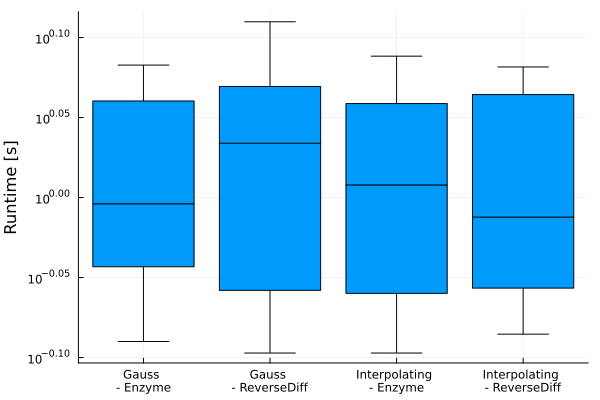

In [19]:
xaxis = repeat(["Interpolating \n- ReverseDiff", "Interpolating \n- Enzyme", "Gauss \n- ReverseDiff", "Gauss \n- Enzyme"], outer=20)
boxplot(xaxis, reduce(vcat, [runtime1, runtime2, runtime3, runtime4]), ylabel="Runtime [s]", label=false, yaxis=:log10)

Overall we see that `InterpolatingAdjoint` and `GaussAdjoint` are comparable, as well as the different VJP approaches.

Benchmarking adjoint algorithms can be valuable to reduce runtime, still some things should be kept in mind. For problems having a similar size to the case study above ($\leq$ 75 parameters), a forward gradient method is recommended as it allows the Gauss-Newton Hessian approximation to be computed, which typically outperforms the (L)BFGS Hessian approximation which must be used when adjoint methods are employed, more details can be found [here](https://sebapersson.github.io/PEtab.jl/stable/Best_options/). Additionally, adjoint sensitivity analysis in Julia is not as reliable as in AMICI. Therefore, if you encounter frequent integration failures consider AMICI.